In [13]:
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import oandapyV20
import configparser
import datetime
from datetime import datetime, timedelta

In [15]:
# config = configparser.ConfigParser()
# config.read(r"../config/config_V20.txt")
# accountID = ""
# api_key = ""
# accountID = config['oanda']['account_id']
# api_key = config['oanda']['api_key']

In [16]:
# import oandapyV20.endpoints.instruments as instruments
# oanda = oandapyV20.API(environment='practice',
#                       access_token=api_key)
# params = {
#     'granularity': 'H1'
# }
# r = instruments.InstrumentsCandles(instrument="EUR_USD",params=params)
# oanda.request(r)
# r.response

In [17]:
# res = pd.DataFrame(r.response["candles"])
# res.head()

In [18]:
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
import pandas as pd
from datetime import datetime
# start～endまでのデータ取得
def get_period_data(start, end, minute, instrument='USD_JPY'):
    timestamp = start.timestamp()
    concats = []
    count = 5000
    while True:
        df, last_timestamp = send_api(count, timestamp, minute, instrument)
        concats.append(df)
#         print(df)
        if last_timestamp > end.timestamp() or len(df) < count:
            break
        timestamp = last_timestamp + (60 * minute)
    df = pd.concat(concats)
    if end is None:
        print(df)
        return df
    else:
        return df[df.index < end]
# 時間足のdfを取得
def send_api(count, start, minute, instrument):
    # oandaへのリクエストの送信
    #api_key = '取得したアクセストークンを入れてください'
    api = API(access_token=api_key, environment="practice", headers={"Accept-Datetime-Format":"Unix"})
    if minute == 1/60:
        granularity = 'S5'
    elif minute == 1:
        granularity = 'M1'
    elif minute == 5:
        granularity = 'M5'
    elif minute == 15:
        granularity = 'M15'
    elif minute == 60:
        granularity = 'H1'
    params = {
        'count': count,
        'granularity': granularity,
    }
    if start is not None:
        params['from'] = start
    r = instruments.InstrumentsCandles(instrument=instrument, params=params)
    response = api.request(r)

    # レスポンスの整形
    def join_json(candle):
        tmp = candle['mid']
        tmp['time'] = candle['time']
        tmp['v'] = candle['volume']
        tmp['complete'] = candle['complete']
        return tmp
    data_list = [join_json(candle) for candle in response['candles']]
    df = pd.DataFrame(data_list)
    last_timestamp = int(float(df.iloc[-1]['time']))
    
    # 型変更
    df['time'] = df['time'].astype('float64')
    df['o'] = df['o'].astype('float64')
    df['h'] = df['h'].astype('float64')
    df['l'] = df['l'].astype('float64')
    df['c'] = df['c'].astype('float64')
    df['v'] = df['v'].astype('float64')

    # タイムゾーンの変更、インデックス化
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df['time'] = df['time'] + pd.Timedelta('09:00:00') # 日本時間へ変換
    df.set_index('time', inplace=True)                 # 時間をインデックスにする
    df = df.loc[:,['o','h','l', 'c', 'v', 'complete']] # 列の順番変更
    df = df.rename(columns={'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close', 'v': 'amount'})

    return df, last_timestamp
minute = 60
start = datetime.strptime('2018-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
# end = datetime.now()
end = datetime.strptime('2019-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
df = get_period_data(start, end, minute, instrument='USD_JPY')
df = df.reset_index().drop_duplicates(subset='time',keep='first').set_index('time')
df

,open,high,low,close,amount,complete
time,,,,,,
2018-01-02 07:00:00,112.666,112.692,112.582,112.592,749.0,True
2018-01-02 08:00:00,112.594,112.790,112.594,112.773,1220.0,True
2018-01-02 09:00:00,112.775,112.793,112.722,112.736,381.0,True
2018-01-02 10:00:00,112.738,112.752,112.659,112.723,618.0,True
2018-01-02 11:00:00,112.720,112.751,112.704,112.714,319.0,True
...,...,...,...,...,...,...
2018-12-31 19:00:00,110.148,110.155,110.006,110.040,842.0,True
2018-12-31 20:00:00,110.038,110.065,109.883,109.943,862.0,True
2018-12-31 21:00:00,109.946,109.972,109.827,109.877,1064.0,True


In [19]:
df_open = df.drop(columns=['complete']) #Mistake in naming the variable...:( it's not supposed to be df_open
df_open

,open,high,low,close,amount
time,,,,,
2018-01-02 07:00:00,112.666,112.692,112.582,112.592,749.0
2018-01-02 08:00:00,112.594,112.790,112.594,112.773,1220.0
2018-01-02 09:00:00,112.775,112.793,112.722,112.736,381.0
2018-01-02 10:00:00,112.738,112.752,112.659,112.723,618.0
2018-01-02 11:00:00,112.720,112.751,112.704,112.714,319.0
...,...,...,...,...,...
2018-12-31 19:00:00,110.148,110.155,110.006,110.040,842.0
2018-12-31 20:00:00,110.038,110.065,109.883,109.943,862.0
2018-12-31 21:00:00,109.946,109.972,109.827,109.877,1064.0


In [20]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_open, test_size=0.20, shuffle=False)

In [21]:
train

,open,high,low,close,amount
time,,,,,
2018-01-02 07:00:00,112.666,112.692,112.582,112.592,749.0
2018-01-02 08:00:00,112.594,112.790,112.594,112.773,1220.0
2018-01-02 09:00:00,112.775,112.793,112.722,112.736,381.0
2018-01-02 10:00:00,112.738,112.752,112.659,112.723,618.0
2018-01-02 11:00:00,112.720,112.751,112.704,112.714,319.0
...,...,...,...,...,...
2018-10-18 01:00:00,112.205,112.300,112.160,112.297,1184.0
2018-10-18 02:00:00,112.299,112.382,112.264,112.330,1050.0
2018-10-18 03:00:00,112.337,112.516,112.337,112.494,1951.0


In [22]:
test

,open,high,low,close,amount
time,,,,,
2018-10-18 06:00:00,112.660,112.720,112.648,112.691,686.0
2018-10-18 07:00:00,112.689,112.716,112.612,112.624,554.0
2018-10-18 08:00:00,112.626,112.686,112.598,112.626,360.0
2018-10-18 09:00:00,112.624,112.730,112.561,112.672,1099.0
2018-10-18 10:00:00,112.670,112.678,112.534,112.556,938.0
...,...,...,...,...,...
2018-12-31 19:00:00,110.148,110.155,110.006,110.040,842.0
2018-12-31 20:00:00,110.038,110.065,109.883,109.943,862.0
2018-12-31 21:00:00,109.946,109.972,109.827,109.877,1064.0


In [23]:
train.shape, test.shape

((4968, 5), (1242, 5))

In [24]:
window_len = 24

In [25]:
# temp = train[0:window_len].copy()
# for col in train:
#     temp.loc[:, col] = temp[col] / temp[col].iloc[0] - 1
#     print(temp.loc[:, col])
# (train['close'][window_len:].values / train['close'][:-window_len].values) -1


time
2018-01-02 07:00:00    0.000000
2018-01-02 08:00:00   -0.000639
2018-01-02 09:00:00    0.000967
2018-01-02 10:00:00    0.000639
2018-01-02 11:00:00    0.000479
2018-01-02 12:00:00    0.000408
2018-01-02 13:00:00    0.000346
2018-01-02 14:00:00    0.000408
2018-01-02 15:00:00    0.000222
2018-01-02 16:00:00    0.000027
2018-01-02 17:00:00   -0.000337
2018-01-02 18:00:00   -0.002503
2018-01-02 19:00:00   -0.003657
2018-01-02 20:00:00   -0.004660
2018-01-02 21:00:00   -0.003834
2018-01-02 22:00:00   -0.004473
2018-01-02 23:00:00   -0.004828
2018-01-03 00:00:00   -0.003870
2018-01-03 01:00:00   -0.004562
2018-01-03 02:00:00   -0.004349
2018-01-03 03:00:00   -0.003355
2018-01-03 04:00:00   -0.002947
2018-01-03 05:00:00   -0.003604
2018-01-03 06:00:00   -0.003515
Name: open, dtype: float64
time
2018-01-02 07:00:00    0.000000
2018-01-02 08:00:00    0.000870
2018-01-02 09:00:00    0.000896
2018-01-02 10:00:00    0.000532
2018-01-02 11:00:00    0.000524
2018-01-02 12:00:00    0.000257
201

array([-0.00321515, -0.00458443, -0.00351263, ...,  0.00278119,
        0.00272659,  0.0035455 ])

# The Meaning of lstm_train_out?
## window_len+1 th number / 0th number - 1??

In [26]:
train_lstm_in = []
for i in range(len(train)-window_len):
    temp = train[i:(i+window_len)].copy()
    for col in train:
        temp.loc[:, col] = temp[col] / temp[col].iloc[0] - 1
    train_lstm_in.append(temp)
lstm_train_out = (train['close'][window_len:].values / train['close'][:-window_len].values)-1

test_lstm_in = []
for i in range(len(test) - window_len):
    temp = test[i:(i + window_len)].copy()
    for col in test:
        temp.loc[:, col] = temp[col] / temp[col].iloc[0] - 1
    test_lstm_in.append(temp)
lstm_test_out = (test['close'][window_len:].values / test['close'][:-window_len].values)-1

In [27]:
train_lstm_in = [np.array(train_lstm_input) for train_lstm_input in train_lstm_in]
train_lstm_in = np.array(train_lstm_in)
# train_lstm_in.shape

test_lstm_in = [np.array(test_lstm_input) for test_lstm_input in test_lstm_in]
test_lstm_in = np.array(test_lstm_in)
test_lstm_in.shape

# for train_lstm_input in train_lstm_in:
#     print(train_lstm_input)
#     print(len(train_lstm_input))
#     print(np.array(train_lstm_input))
#     print(np.array(train_lstm_input).shape)
#     print("\n")

(1218, 24, 5)

In [28]:
train_lstm_in.shape

(4944, 24, 5)

In [29]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [30]:
def build_model(inputs, output_size, neurons, activ_func="linear",
               dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()
    
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    
    model.compile(loss=loss, optimizer=optimizer)
    return model

np.random.seed(202)

yen_model = build_model(train_lstm_in, output_size=1, neurons=20)

yen_history = yen_model.fit(train_lstm_in, lstm_train_out, epochs=50, batch_size=1, verbose=2, shuffle=True)


Epoch 1/50
 - 112s - loss: 0.0115
Epoch 2/50
 - 109s - loss: 0.0018
Epoch 3/50
 - 109s - loss: 0.0014
Epoch 4/50
 - 109s - loss: 0.0014
Epoch 5/50
 - 108s - loss: 0.0013
Epoch 6/50
 - 109s - loss: 0.0013
Epoch 7/50
 - 109s - loss: 0.0012
Epoch 8/50
 - 109s - loss: 0.0012
Epoch 9/50
 - 108s - loss: 0.0011
Epoch 10/50
 - 109s - loss: 0.0012
Epoch 11/50
 - 109s - loss: 0.0012
Epoch 12/50
 - 109s - loss: 0.0012
Epoch 13/50
 - 109s - loss: 0.0012
Epoch 14/50
 - 107s - loss: 0.0011
Epoch 15/50
 - 110s - loss: 0.0011
Epoch 16/50
 - 108s - loss: 0.0011
Epoch 17/50
 - 109s - loss: 0.0011
Epoch 18/50
 - 109s - loss: 0.0011
Epoch 19/50
 - 108s - loss: 0.0011
Epoch 20/50
 - 108s - loss: 0.0011
Epoch 21/50
 - 110s - loss: 0.0011
Epoch 22/50
 - 109s - loss: 0.0011
Epoch 23/50
 - 109s - loss: 0.0011
Epoch 24/50
 - 109s - loss: 0.0011
Epoch 25/50
 - 109s - loss: 0.0011
Epoch 26/50
 - 109s - loss: 0.0011
Epoch 27/50
 - 109s - loss: 0.0011
Epoch 28/50
 - 108s - loss: 0.0011
Epoch 29/50
 - 109s - loss: 

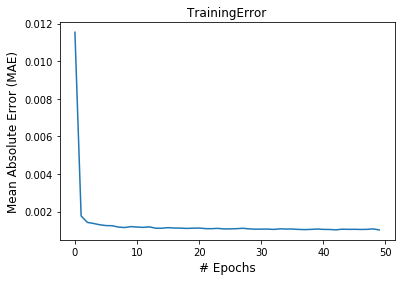

In [35]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(yen_history.epoch, yen_history.history['loss'])
ax1.set_title('TrainingError')

if yen_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

STD of train data[close]: 2.1931426704170915
RMSE: 0.15092276404269644
Percentage RMSE/STD: 6.88%


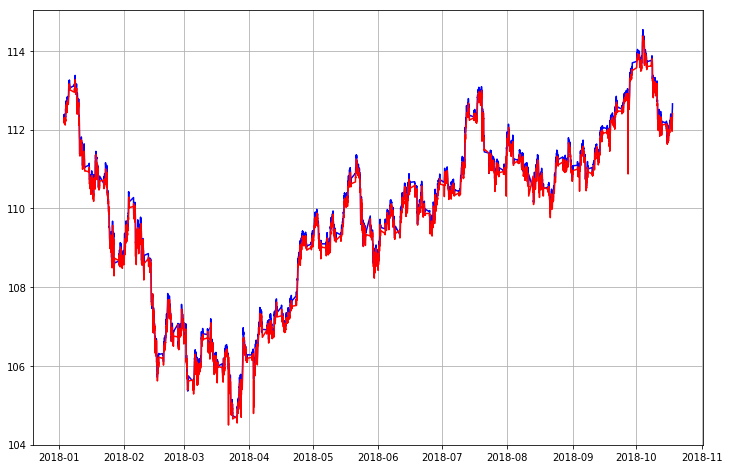

In [85]:
from statsmodels.tools.eval_measures import rmse
fig, ax1 = plt.subplots(1,1,figsize=(12,8))
ax1.plot(train.index[window_len:],
    train['close'][window_len:], label='Actual', color='blue')
ax1.plot(train.index[window_len:],
    ((np.transpose(yen_model.predict(train_lstm_in))+1)*train['close'].values[:-window_len])[0],
            label='Predicted', color='red')
ax1.grid(True)

error_train = rmse(train['close'][window_len:], ((np.transpose(yen_model.predict(train_lstm_in))+1)*train['close'].values[:-window_len])[0])
print('STD of train data[close]: {}'.format(train['close'].std()))
print(f'RMSE: {error_train}')
per = round(error_train/train['close'].std()*100, 2)
print('Percentage RMSE/STD: {}%'.format(per))

STD of test data[close]: 0.8942866792485271
RMSE: 0.41965473762775785
Percentage RMSE/STD: 46.93%


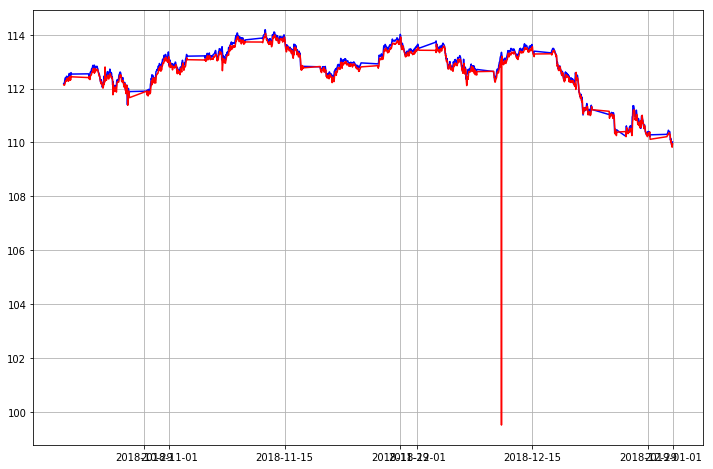

In [86]:
fig, ax1 = plt.subplots(1,1,figsize=(12,8))
ax1.plot(test.index[window_len:],
    test['close'][window_len:], label='Actual', color='blue')
ax1.plot(test.index[window_len:],
    ((np.transpose(yen_model.predict(test_lstm_in))+1)*test['close'].values[:-window_len])[0],
            label='Predicted', color='red')
ax1.grid(True)

error_test = rmse(test['close'][window_len:], ((np.transpose(yen_model.predict(test_lstm_in))+1)*test['close'].values[:-window_len])[0])
print('STD of test data[close]: {}'.format(test['close'].std()))
print(f'RMSE: {error_test}')
per = round(error_test/test['close'].std()*100, 2)
print('Percentage RMSE/STD: {}%'.format(per))

In [72]:
train['close'].std()

2.1931426704170915

In [88]:
df_open.columns[3]

'close'